# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to turn our chatbot into a simple [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/).

The chatbot previously *always* reflected on the conversation and saved memories. 

The central difference is that the agent will decide *when* to save memories. 

For this, we're going to introduce a [router](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) that allows the agent to save memories. 

We're going to make this a fully featured companion chatbot. To do that, we're going to have multiple different memory types. We're going to have one that is a "user profile", and another that remembers information about other important people in the user's life.

In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [ ]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Adding a router

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple: a ReAct agent that decides whether to (a) update the user profile, (b) add an item to the todo list, or (c) update its own instructions on how to update items to the todo list.

In [4]:
_set_env("OPENAI_API_KEY")

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

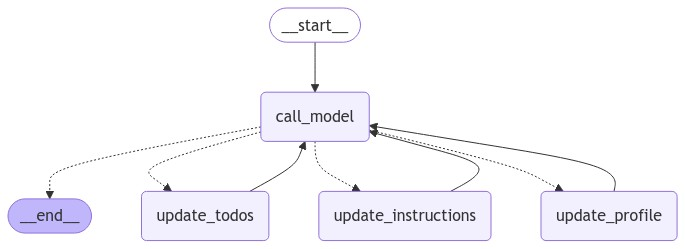

In [44]:
import uuid
from IPython.display import Image, display

from trustcall import create_extractor
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)


# Profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: str = Field(description="The user's name")
    job: str = Field(description="The user's job")
    age: str = Field(description="The user's age")
    interests: list[str] = Field(description="Interests that the user has")


class ToDo(BaseModel):
    """Item on the ToDo list"""
    item: str = Field(description="The thing todo")
    done: bool

# Create the Trustcall extractors
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)
todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice="ToDo",
    enable_inserts=True
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of information you learn about the user over time, as well as key people in their life.

User Profile:
<user_profile>
{user_profile}
</user_profile>

ToDo List:
<todo>
{todo}
</todo>

{instructions}

You are able to update your memory of the user (call `user`), the todo list (call `todo`), or you're also able to update your own instructions on how to create the todo list (call `instructions`)

In order to update the todo list, you MUST call the UpdateMemory tool with type `todo`

Do not tell the user you have updated your profile of the user, or that you have updated instructions.

You should tell them when you update the todo list.

You should err on the side of updating the todo list, no need to ask for explicit permission"""

class UpdateMemory(TypedDict):
    update_type: Literal['user', 'todo', 'instructions']

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Do NOT call the tool UpdateMemory.

Use parallel tool calling to handle updates and insertions simultaneously:"""

CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve people memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}


def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"][:-1]))

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated todo list", "tool_call_id":tool_calls[0]['id']}]}


def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("memory", user_id)

    existing_memory = store.get(namespace, "user_memory")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_memory"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}



# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_conditional_edges("call_model", route_message)
builder.add_edge(START, "call_model")
builder.add_edge("update_todos", "call_model")
builder.add_edge("update_profile", "call_model")
builder.add_edge("update_instructions", "call_model")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [45]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance. I live in SF.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance. I live in SF.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_JZBzSh1kGHUSeGnCzYMzAuU8)
 Call ID: call_JZBzSh1kGHUSeGnCzYMzAuU8
  Args:
    update_type: user


Unrecognized function call Profile


================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Hi Lance! Nice to meet you. How's the weather in San Francisco today?


In [46]:
# User input 
input_messages = [HumanMessage(content="My wife asked me to book a flight to Las Vegas")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book a flight to Las Vegas
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_Z2ViuUtfk3Gy38yBp6i3I7xo)
 Call ID: call_Z2ViuUtfk3Gy38yBp6i3I7xo
  Args:
    update_type: todo
================================= Tool Message =================================

updated todo list
================================== Ai Message ==================================

I've added "Book a flight to Las Vegas for my wife" to your ToDo list. Is there anything else you'd like to add or do today?


In [47]:
# User input 
input_messages = [HumanMessage(content="Add another todo to take out the trash")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Add another todo to take out the trash
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_MPFbtGB2hKxu8bTOv3rszJ5H)
 Call ID: call_MPFbtGB2hKxu8bTOv3rszJ5H
  Args:
    update_type: todo
================================= Tool Message =================================

updated todo list
================================== Ai Message ==================================

I've added "Take out the trash" to your ToDo list. Anything else I can help you with?


In [48]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'item': 'Book a flight to Las Vegas for my wife', 'done': False}
{'item': 'Take out the trash', 'done': False}


In [49]:
# User input 
input_messages = [HumanMessage(content="Ive taken out the trash. Also, in the future, make sure to specify the departure airport when making todo items to book flights")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Ive taken out the trash. Also, in the future, make sure to specify the departure airport when making todo items to book flights
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_M7IJ1e0efbciNHasKkCpHGrB)
 Call ID: call_M7IJ1e0efbciNHasKkCpHGrB
  Args:
    update_type: todo
================================= Tool Message =================================

updated todo list
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_cx9PUGWSAR82TNxmeR7ts8T3)
 Call ID: call_cx9PUGWSAR82TNxmeR7ts8T3
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Great job on taking out the trash! I've marked that as done on your ToDo list

In [50]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    print(memory.value)

{'item': 'Book a flight from SF to Las Vegas for my wife', 'done': False}
{'item': 'Take out the trash', 'done': True}


In [51]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("memory", user_id)):
    print(memory.value)

{'memory': 'Based on our conversation, here are the updated instructions for managing ToDo list items:\n\n1. When adding a flight booking to the ToDo list, specify the departure airport. For example, "Book a flight from SFO to Las Vegas for my wife."\n\n2. When a task is completed, such as "Take out the trash," mark it as done or remove it from the list.\n\n3. Confirm with the user after adding or updating a ToDo item to ensure accuracy and completeness.\n\nIf there\'s anything else you\'d like to adjust or add, feel free to let me know!'}


In [53]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("profile", user_id)):
    print(memory.value)

{'name': 'Lance', 'job': 'Unknown', 'age': 'Unknown', 'interests': []}


Now we can create a new thread and chat with the chatbot again.

It should retain the memories from the previous thread!

In [54]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Hi!")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

Hello Lance! How can I assist you today?


In [55]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I need to book a flight for Jim to Boston")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to book a flight for Jim to Boston
================================== Ai Message ==================================

I'll add that to your ToDo list.

- Book a flight for Jim to Boston

Is there anything else you'd like to do?


Trace: 

https://smith.langchain.com/public/f267e203-d78a-4884-898f-8d5c84d5597c/r

## TODO: Show in Studio
